In [1]:
from pathlib import Path
import json

PROJECT = Path("/root/Course/final_project")
DATA_DIR = PROJECT / "nmt_data_jieba_100k"

VOCAB_ZH = DATA_DIR / "vocab_zh.json"
VOCAB_EN = DATA_DIR / "vocab_en.json"

TRAIN_TOK = DATA_DIR / "train_tok.jsonl"
VALID_TOK = DATA_DIR / "valid_tok.jsonl"
TEST_TOK  = DATA_DIR / "test_tok.jsonl"


In [3]:
import json

with open(TRAIN_TOK, "r", encoding="utf-8") as f:
    first = json.loads(next(f))

first


{'src_tokens': ['1929', '年', '还是', '1989', '年', '?'],
 'tgt_tokens': ['1929', 'or', '1989', '?'],
 'src_ids': [2, 6171, 27, 291, 2692, 27, 6007, 3],
 'tgt_ids': [2, 6822, 37, 2958, 99, 3]}

In [4]:
import json, pandas as pd

def toklist_to_text_zh(toks):
    # 中文：通常不加空格更自然（mT5 用 sentencepiece，不靠空格分词）
    return "".join(toks)

def toklist_to_text_en(toks):
    # 英文：用空格拼回去
    return " ".join(toks)

def read_tok_jsonl(path, max_rows=None):
    rows = []
    with open(path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if max_rows is not None and i >= max_rows:
                break
            j = json.loads(line)
            rows.append({
                "src_text": toklist_to_text_zh(j["src_tokens"]),
                "tgt_text": toklist_to_text_en(j["tgt_tokens"]),
            })
    return pd.DataFrame(rows)

# 用你已有的 TRAIN_TOK / VALID_TOK / TEST_TOK 路径
df_train = read_tok_jsonl(TRAIN_TOK)
df_valid = read_tok_jsonl(VALID_TOK)
df_test  = read_tok_jsonl(TEST_TOK)

df_train.head()


,src_text,tgt_text
0,1929年还是1989年?,1929 or 1989 ?
1,巴黎-随着经济危机不断加深和蔓延，整个世界一直在寻找历史上的类似事件希望有助于我们了解目前正...,PARIS – As the economic crisis deepens and wid...
2,一开始，很多人把这次危机比作1982年或1973年所发生的情况，这样得类比是令人宽心的，因为...,"At the start of the crisis , many people liken..."
3,如今人们的心情却是沉重多了，许多人开始把这次危机与1929年和1931年相比，即使一些国家政...,"Today , the mood is much grimmer , with refere..."
4,目前的趋势是，要么是过度的克制（欧洲），要么是努力的扩展（美国）。,The tendency is either excessive restraint ( E...


In [5]:
from datasets import Dataset, DatasetDict

ds = DatasetDict({
    "train": Dataset.from_pandas(df_train),
    "validation": Dataset.from_pandas(df_valid),
    "test": Dataset.from_pandas(df_test),
})
ds


DatasetDict({
    train: Dataset({
        features: ['src_text', 'tgt_text'],
        num_rows: 99102
    })
    validation: Dataset({
        features: ['src_text', 'tgt_text'],
        num_rows: 486
    })
    test: Dataset({
        features: ['src_text', 'tgt_text'],
        num_rows: 179
    })
})

In [6]:
import os
os.environ["TRANSFORMERS_OFFLINE"] = "1"

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

MODEL_DIR = "/root/LLMs/mt5-small"

tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR, local_files_only=True, use_fast=False)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_DIR, local_files_only=True)


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [7]:
max_src_len = 128
max_tgt_len = 128

def preprocess(examples):
    model_inputs = tokenizer(
        examples["src_text"],
        max_length=max_src_len,
        truncation=True,
    )
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples["tgt_text"],
            max_length=max_tgt_len,
            truncation=True,
        )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized = ds.map(preprocess, batched=True, remove_columns=["src_text", "tgt_text"])
tokenized


Map:   0%|          | 0/99102 [00:00<?, ? examples/s]

/root/miniconda3/envs/py311/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:4169: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/486 [00:00<?, ? examples/s]

Map:   0%|          | 0/179 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 99102
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 486
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 179
    })
})

In [11]:
import sys
import numpy as np
from transformers import DataCollatorForSeq2Seq, Seq2SeqTrainer, Seq2SeqTrainingArguments

project_root = '/root/Course/final_project'  # 替换为你的实际路径
sys.path.insert(0, project_root)
from bleu import corpus_bleu

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

def simple_en_tokenize(s: str):
    # 你的英文目标是用空格拼出来的，所以这里按空格切就能对齐
    return s.strip().split()

def compute_metrics(eval_pred):
    preds, labels = eval_pred

    # labels 里 -100 需要替换成 pad 才能 decode
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    pred_texts = tokenizer.batch_decode(preds, skip_special_tokens=True)
    ref_texts  = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # corpus_bleu 需要: candidates = List[List[str]], references = List[List[str]]
    cands = [simple_en_tokenize(x) for x in pred_texts]
    refs  = [simple_en_tokenize(x) for x in ref_texts]

    bleu4 = corpus_bleu(cands, refs, max_n=4) * 100
    return {"bleu4": bleu4}

args = Seq2SeqTrainingArguments(
    output_dir="/root/Course/final_project/mt5_finetune_runs/mt5-small-zh2en",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,
    learning_rate=5e-5,
    num_train_epochs=3,

    do_train=True,
    do_eval=True,

    predict_with_generate=True,
    generation_max_length=80,

    eval_strategy="epoch",     # <-- 关键：旧版用这个
    save_strategy="epoch",
    logging_steps=100,

    bf16=True,
    fp16=False,
    report_to="none",
)


trainer = Seq2SeqTrainer(
    model=model,
    args=args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()


/tmp/ipykernel_710451/4182328958.py:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
/root/miniconda3/envs/py311/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Bleu4
1,4.151300,3.219143,1.794318
2,3.556000,3.066758,2.702148
3,3.427600,3.026553,2.925132


/root/miniconda3/envs/py311/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/root/miniconda3/envs/py311/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=1164, training_loss=4.365398878903733, metrics={'train_runtime': 739.9684, 'train_samples_per_second': 401.782, 'train_steps_per_second': 1.573, 'total_flos': 2.117556590149632e+16, 'train_loss': 4.365398878903733, 'epoch': 3.0})

In [12]:
trainer.evaluate(tokenized["test"], metric_key_prefix="test")

/root/miniconda3/envs/py311/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'test_loss': 3.1580867767333984,
 'test_bleu4': 2.058562328280372,
 'test_runtime': 1.7974,
 'test_samples_per_second': 99.587,
 'test_steps_per_second': 1.113,
 'epoch': 3.0}

Although the fine-tuned mT5 model does not significantly outperform the Transformer trained from scratch on this dataset, it achieves comparable performance with substantially fewer training epochs, demonstrating the benefit of large-scale pretraining.

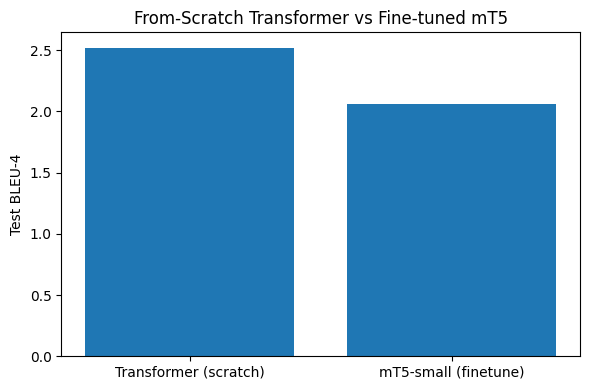

In [2]:
import matplotlib.pyplot as plt

models = ["Transformer (scratch)", "mT5-small (finetune)"]
bleu = [2.52, 2.06]  # 用你自己的真实数值

plt.figure(figsize=(6,4))
plt.bar(models, bleu)
plt.ylabel("Test BLEU-4")
plt.title("From-Scratch Transformer vs Fine-tuned mT5")
plt.tight_layout()
plt.show()
